In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import xgboost as xgb
import yfinance as yf
import seaborn as sns

from arch import arch_model
from sklearn.model_selection import train_test_split
from arch.__future__ import reindexing

#### Future volatility prediction using GARCH

In [4]:

ticker = '^GSPC'

# Import stock data
data = pd.DataFrame(yf.download(ticker, period='10Y', interval='1d', progress=False, ignore_tz=True)['Adj Close'])

def add_GARCH(df, test_size = 2500):
    rolling_predictions = list()
    df['log_returns'] = np.log(df['Adj Close']/df['Adj Close'].shift())

    for i in range(test_size):
        train = df['log_returns'].dropna()[:-(test_size-i)]
        model = arch_model(100 * train, p=1, q=1, mean='constant', vol='GARCH')
        model_fit = model.fit(disp='off')
        pred = model_fit.forecast(horizon=1, reindex=True)
        rolling_predictions.append(np.sqrt(pred.variance.values[-1,:][0]))

    df['GARCH'] = pd.Series(rolling_predictions, index=df['log_returns'].index[-test_size:]) / 100

    return df

data = add_GARCH(data)

display(data)


,Adj Close
Date,
2013-07-01,1614.959961
2013-07-02,1614.079956
2013-07-03,1615.410034
2013-07-05,1631.890015
2013-07-08,1640.459961
...,...
2023-06-26,4328.819824
2023-06-27,4378.410156
2023-06-28,4376.859863


In [5]:
data['SMA_7'] = data['Adj Close'].rolling(window=7).mean()
data['SMA_14'] = data['Adj Close'].rolling(window=14).mean()

data['std_roll'] = data['Adj Close'].rolling(window=7).std()

# data['hour'] = data.index.hour
data['dayofyear'] = data.index.day_of_year
data['dayofweek'] = data.index.day_of_week
data['quarter'] = data.index.quarter
data['month'] = data.index.month
data['year'] = data.index.year

data = data.dropna()

display(data)

,Adj Close,log_returns,GARCH,SMA_7,SMA_14,std_roll,dayofyear,dayofweek,quarter,month,year
Date,,,,,,,,,,,
2013-07-26,1691.650024,0.000828,0.003901,1691.031424,1681.217137,2.968742,207,4,3,7,2013
2013-07-29,1685.329956,-0.003743,0.003549,1690.454276,1683.574995,3.658216,210,0,3,7,2013
2013-07-30,1685.959961,0.000374,0.003860,1689.578561,1685.956421,3.925356,211,1,3,7,2013
2013-07-31,1685.729980,-0.000136,0.003530,1688.178554,1686.721418,3.112394,212,2,3,7,2013
2013-08-01,1706.869995,0.012463,0.003238,1690.247123,1688.627136,7.743844,213,3,3,8,2013
...,...,...,...,...,...,...,...,...,...,...,...
2023-06-26,4328.819824,-0.004497,0.007363,4378.409947,4348.111398,33.827406,177,0,2,6,2023
2023-06-27,4378.410156,0.011391,0.007163,4371.634277,4354.865688,26.754431,178,1,2,6,2023
2023-06-28,4376.859863,-0.000354,0.008116,4366.958566,4362.675677,21.324646,179,2,2,6,2023


In [6]:
test_size = 0.25

features = ['dayofyear', 'dayofweek', 'month', 'SMA_7', 'SMA_14', 'Adj Close']
targets = ['GARCH']

display(data[features])

n_train = int(len(data)*(1-test_size))

x_train = data[features].iloc[:n_train]
x_test = data[features].iloc[n_train:]
y_train = data[targets].iloc[:n_train]
y_test = data[targets].iloc[n_train:]

model = xgb.XGBRegressor(n_estimators=5000, early_stopping_rounds=50)
model.fit(x_train, y_train, eval_set=[(x_train, y_train), (x_test, y_test)], verbose=True)

display(pd.DataFrame(data=model.feature_importances_, index=model.feature_names_in_, columns=["Importance"]))

,dayofyear,dayofweek,month,SMA_7,SMA_14,Adj Close
Date,,,,,,
2013-07-26,207,4,7,1691.031424,1681.217137,1691.650024
2013-07-29,210,0,7,1690.454276,1683.574995,1685.329956
2013-07-30,211,1,7,1689.578561,1685.956421,1685.959961
2013-07-31,212,2,7,1688.178554,1686.721418,1685.729980
2013-08-01,213,3,8,1690.247123,1688.627136,1706.869995
...,...,...,...,...,...,...
2023-06-26,177,0,6,4378.409947,4348.111398,4328.819824
2023-06-27,178,1,6,4371.634277,4354.865688,4378.410156
2023-06-28,179,2,6,4366.958566,4362.675677,4376.859863


[0]	validation_0-rmse:0.34416	validation_1-rmse:0.34180
[1]	validation_0-rmse:0.24101	validation_1-rmse:0.23863
[2]	validation_0-rmse:0.16880	validation_1-rmse:0.16641
[3]	validation_0-rmse:0.11827	validation_1-rmse:0.11585
[4]	validation_0-rmse:0.08292	validation_1-rmse:0.08047
[5]	validation_0-rmse:0.05822	validation_1-rmse:0.05572
[6]	validation_0-rmse:0.04091	validation_1-rmse:0.03871
[7]	validation_0-rmse:0.02881	validation_1-rmse:0.02673
[8]	validation_0-rmse:0.02038	validation_1-rmse:0.01858
[9]	validation_0-rmse:0.01447	validation_1-rmse:0.01392
[10]	validation_0-rmse:0.01039	validation_1-rmse:0.00993
[11]	validation_0-rmse:0.00759	validation_1-rmse:0.00743
[12]	validation_0-rmse:0.00561	validation_1-rmse:0.00691
[13]	validation_0-rmse:0.00437	validation_1-rmse:0.00603
[14]	validation_0-rmse:0.00351	validation_1-rmse:0.00550
[15]	validation_0-rmse:0.00288	validation_1-rmse:0.00533
[16]	validation_0-rmse:0.00254	validation_1-rmse:0.00518
[17]	validation_0-rmse:0.00227	validation

,Importance
dayofyear,0.069554
dayofweek,0.015586
month,0.089187
SMA_7,0.149387
SMA_14,0.227999
Adj Close,0.448287


['GARCH']


,dayofyear,dayofweek,month,SMA_7,SMA_14,Adj Close,GARCH,GARCH_pred
Date,,,,,,,,
2021-01-06,6,2,1,3732.308594,3716.747855,3748.139893,0.008700,0.008371
2021-01-07,7,3,1,3742.084298,3724.077863,3803.790039,0.008080,0.008371
2021-01-08,8,4,1,3756.032854,3731.377860,3824.679932,0.009807,0.008371
2021-01-11,11,0,1,3765.685721,3737.820731,3799.610107,0.008936,0.008371
2021-01-12,12,1,1,3772.131417,3745.411447,3801.189941,0.008694,0.008371
...,...,...,...,...,...,...,...,...
2023-06-26,177,0,6,4378.409947,4348.111398,4328.819824,0.007363,0.011019
2023-06-27,178,1,6,4371.634277,4354.865688,4378.410156,0.007163,0.011019
2023-06-28,179,2,6,4366.958566,4362.675677,4376.859863,0.008116,0.011019


1875


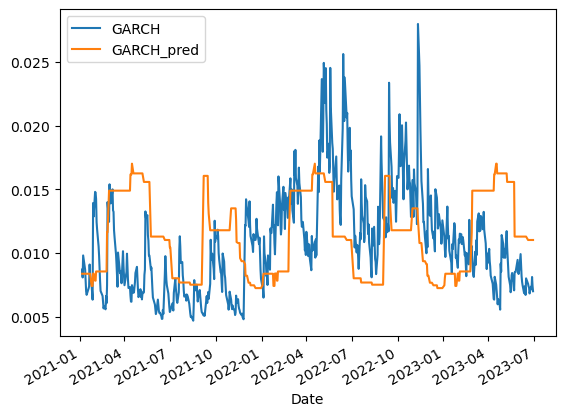

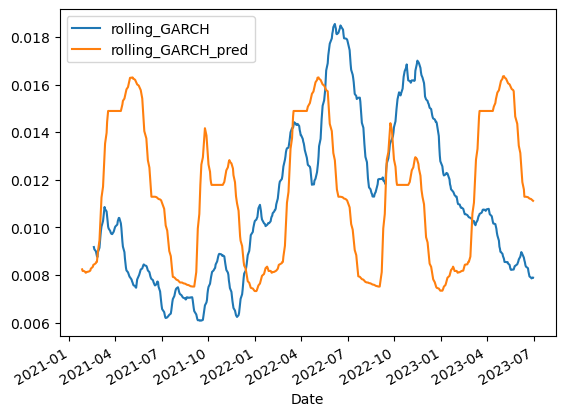

In [9]:
pred_cols = [target + "_pred" for target in targets]

print(targets)

test_pred = pd.DataFrame(data=model.predict(x_test), columns=pred_cols, index=data[targets].index[n_train:])

# Combining test data and
compare = pd.concat([x_test.set_index(data[targets].index[n_train:]), 
                     y_test.set_index(data[targets].index[n_train:]), 
                     test_pred], axis=1)

display(compare)

compare['rolling_GARCH'] = compare['GARCH'].rolling(30).mean()
compare['rolling_GARCH_pred'] = compare['GARCH_pred'].rolling(14).mean()

compare.plot(y=['GARCH', 'GARCH_pred'])
compare.plot(y=['rolling_GARCH', 'rolling_GARCH_pred'])
# compare.plot(y=['Adj Close', 'Adj Close_pred'])

print(len(x_train))